Some references:
1. https://www.datasciencecentral.com/profiles/blogs/some-more-social-network-analysis-with-python-centrality-pagerank

2. http://blog.samuelmh.com/2015/02/pagerank-sparse-matrices-python-ipython.html

3. https://github.com/MaxPoon/coursera-Applied-Data-Science-with-Python/tree/master/Applied-Social-Network-Analysis-In-Python/week4

Scaled PageRank:
1. https://github.com/MaxPoon/coursera-Applied-Data-Science-with-Python/blob/204c39794a9966f967d71e5e3fa277eb4bbcae74/Applied-Social-Network-Analysis-In-Python/week3/Assignment%2B3.ipynb

2. https://www.coursera.org/learn/python-social-network-analysis/lecture/xxW11/scaled-page-rank

## Page Rank Introduction
PageRank relies on the uniquely democratic nature of the Web by using its vast link structure as an indicator of an individual page’s value.

### Google Matrix
(https://medium.com/@bgoncalves/network-effects-explained-pagerank-and-preferential-attachment-61fdf93d023a)
Google provides its views on pages’ relative importance. This idea is extremely simple. The importance of each page is the average of the importance of every page that points to it. 

We can generate the Google Matrix from the adjacency matrix in a straightforward manner. Here we assign each node the same "importance", say, m, and make every node play a simple game: Look at your outgoing links and evenly send each page you point to an equal share of your current importance. 

In [67]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
plotly.tools.set_credentials_file(username='Yiming_Gao', api_key='8aK9bpc31YdCuAqEBv7m')
# import visJS2jupyter.visJS_module

In [2]:
filename = "celegans.txt"
N = 297
m = 0.15
iter = 1000

In [3]:
# Read the adjacency matrix from file
A = np.zeros((N, N))
for line in open(filename):
    node_i, node_j = line.strip().split()

    node_i = int(node_i)
    node_j = int(node_j)

    A[node_i, node_j] = 1

v = np.ones(N)

We can generate the Google Matrix from the adjacency matrix in a straightforward manner:

In [4]:
def Google_Matrix(A, m):
    N = A.shape[0]
    v = np.ones(N)

    # Calculate the degree of each node
    KT = np.dot(A.T, v)

    # Normalize the columns
    for i in range(N):
        A.T[i] = A.T[i]/KT[i]

    # Add random links
    S = np.ones((N, N))/N
    G = (1-m)*A+m*S

    return G

Since we are interested in the eigenvector corresponding to the largest eigenvalue (with value one) we can use the Power Method to calculate the eigenvector in an efficient way, by repeated multiplication by a normalized vector:

In [5]:
#Perform the power method for "iter" iterations
def Power_Method(G, iter):
    N = G.shape[0]
    x0 = np.ones(N)/N

    for i in range(iter):
        x0 = np.dot(G, x0)

    return x0

If we now plot the elements of the PageRank vector as a function of the number of connections each node has, its degree, we notice that there is a strong, although not perfect, correlation between the two:

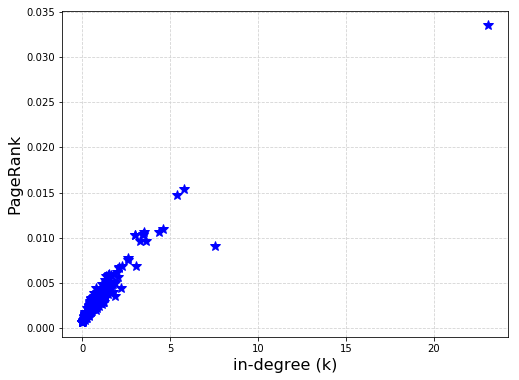

In [6]:
G = Google_Matrix(A, m)
x0 = Power_Method(G, iter)

# in-degree
deg = A.sum(axis=1)

fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(deg, x0, "b*", markersize = 10)
plt.xlabel('in-degree (k)', fontsize = 16)
plt.ylabel('PageRank', fontsize = 16)
plt.grid(color = 'lightgray', linestyle = '--')
plt.savefig('PageRank.png')
plt.show()
# PageRank as a function of degree

The more incoming connections a node has the higher its PageRank. 

## Randomly Generated Graphs
We will first generate input graphs using three types of graphs:
- Preferential Attachment
- Small World with low probability of rewiring
- Small World with high probability of rewiring

### Preferential Attachment Model
**1. Degree Distributions**

The degree distribution of a graph is the probability distribution of the degrees over the entire network.

https://github.com/MaxPoon/coursera-Applied-Data-Science-with-Python/blob/master/Applied-Social-Network-Analysis-In-Python/week4/4.1_Preferential-Attachment-Model.pdf

**2. Preferential Attachment Model**
- Start with two nodes connected by an edge
- At each time step, add a new node with an edge connecting it to an existing node
- Choose the node to connect to at random with probability proportional to each node's degree
- The probability of connecting to a node *u* of degree *$k_u$* is $k_u/\sum_j k_j$

做presentation时记得每步说明

As the number of nodes increases, the preferential attachment model produces networks with degree distributions similar to real networks.

**3. Preferential Attachment Model in NetworkX**

barabasi_albert_graph(n, m) returns a network with n nodes. Each new node attaches to m existing nodes according to the Preferential Attachment model.

To illustrate this, we create a graph with 1000000 nodes starting from 1 node.

In [7]:
G = nx.barabasi_albert_graph(1000000, 1)
degrees = G.degree()
degree_values = sorted(set(degrees.values()))
histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]

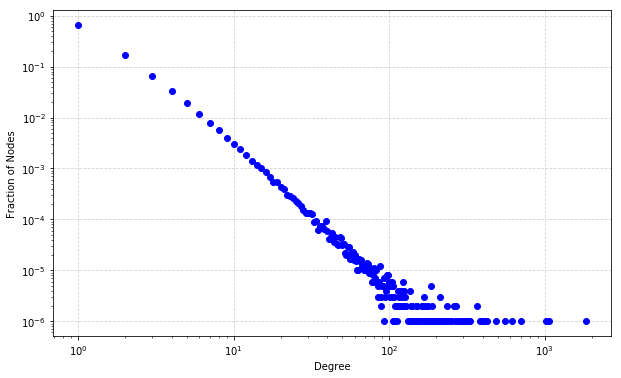

In [8]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(degree_values, histogram, 'bo')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.xscale('log')
plt.yscale('log')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

The resulting degree distribution, the probability $P[k]$ of a node chosen uniformly at random having degree $k$ is clearly broadtail with an exponent of approximately 3.

The figure above shows that nodes of degree 100 are approximately 1,000,000 times **less common** than nodes of degree 1.

A consequence of this form of the degree distribution is the existence of “hubs”, or superstars, nodes that account for a disproportionately large number of connections. For example, in a network of 1,000,000 nodes, the Top 1% of nodes by degree account for roughly 21% of all connections and the Top 10 nodes have over 1.5% of the total. This kind of disparity can be seen in many other cases, such as the accumulation of wealth.

### Small World Model
**1. Motivation**

- Real networks exhibit high clustering coefficient and small average shortest paths. 

- The preferential attachment model produces networks with small short paths but very small clustering coefficient.

**2. Small-world model**

- Start with a ring of n nodes, where each node is connected to its k nearest neighbors
- Fix a parameter $p\in [0, 1]$
- Consider each edge $(u, v)$. With probability $p$, select a node $w$ at random and rewire the edge $(u, v)$ so it becomes $(u, w)$.

**3. Small World Model in NetworkX**

watts_strogatz_graph(n, k, p) returns a small world network with n nodes, starting with a ring lattice with each node connected to its k nearest neighbors, and rewiring probability $p$.

We could have a look at the small world network degree distribution.

In [14]:
G = nx.watts_strogatz_graph(1000, 6, 0.04)
degrees = G.degree()
degree_values = sorted(set(degrees.values()))
histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]

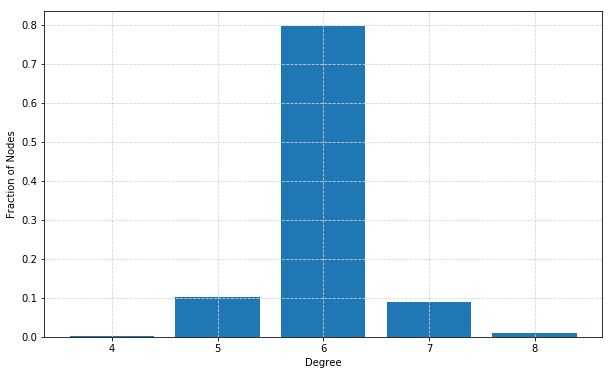

In [15]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.bar(degree_values, histogram)
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

This is a small world network with 1000 nodes, k = 6, and p = 0.04. There is no power law degree distribution.

Meanwhile, since most edges are not rewired, most nodes have degree of 6. Since edges are rewired uniformly at random, no node accumulated very high degree, like in the preferential attachment model.

## GCNN Implementation
https://media.readthedocs.org/pdf/tfgraph/latest/tfgraph.pdf

Implementation of Graph Auto-Encoders in Tensorflow: https://github.com/tkipf/gae

### Input 1: Preferential Attachment Model
First we generate a preferential attachment model with 100 nodes starting from 1 node. Since this creates an undirected graph, we converted it to a directed graph. (CORRECTNESS??)

In [62]:
G_temp = nx.barabasi_albert_graph(100, 1)

# initialize an empty directed graph
G = nx.DiGraph()
G.add_edges_from(G_temp.edges())

We could also visualize this directed graph.

In [75]:
pr = nx.pagerank(G, alpha = 0.85)
nx.set_node_attributes(G, 'score', pr)
nx.set_node_attributes(G, 'pos', nx.random_layout(G))

In [76]:
pos=nx.get_node_attributes(G,'pos')

In [77]:
edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)

In [78]:
for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))
    node_info = '# of connections: '+str(len(adjacencies))
    node_trace['text'].append(node_info)

In [80]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Preferential Attachment Model with 100 Nodes',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='Preferential Attachment Model with 100 Nodes')

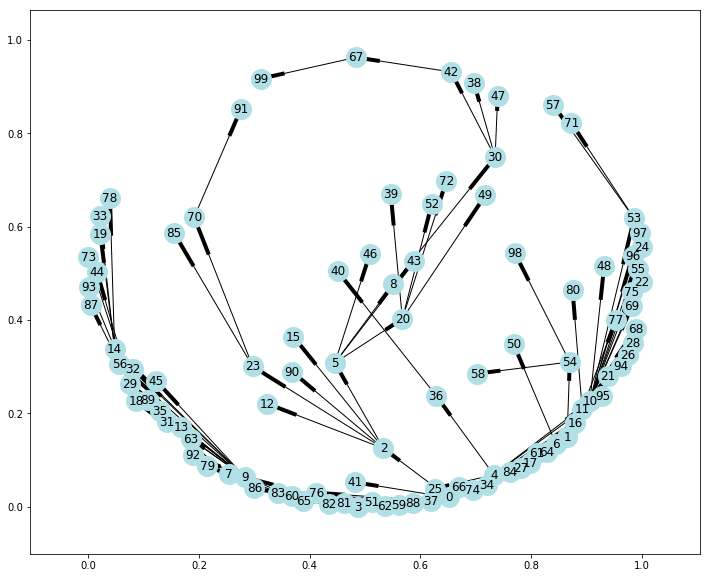

In [63]:
fig, ax = plt.subplots(figsize = (12, 10))
nx.draw_networkx(G, with_labels = True, node_size = 400, node_color = 'powderblue')
plt.show()

### Input 2: Small World Model with Low Rewiring Probability

In [110]:
G_temp = nx.watts_strogatz_graph(100, 10, 0.05)

# initialize an empty directed graph
G = nx.DiGraph()
G.add_edges_from(G_temp.edges())

In [111]:
pr = nx.pagerank(G, alpha = 0.85)
nx.set_node_attributes(G, 'score', pr)
nx.set_node_attributes(G, 'pos', nx.circular_layout(G))
pos=nx.get_node_attributes(G,'pos')

In [112]:
edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)

for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))
    node_info = '# of connections: '+str(len(adjacencies))
    node_trace['text'].append(node_info)

fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Small World Model with Rewiring Probability = 0.05',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='Small World Model with Rewiring Probability = 0.05')

### Input 3: Small World Model with High Rewiring Probability

In [113]:
G_temp = nx.watts_strogatz_graph(100, 10, 0.90)

# initialize an empty directed graph
G = nx.DiGraph()
G.add_edges_from(G_temp.edges())

In [114]:
pr = nx.pagerank(G, alpha = 0.85)
nx.set_node_attributes(G, 'score', pr)
nx.set_node_attributes(G, 'pos', nx.circular_layout(G))
pos=nx.get_node_attributes(G,'pos')

In [115]:
edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)

for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))
    node_info = '# of connections: '+str(len(adjacencies))
    node_trace['text'].append(node_info)

fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Small World Model with Rewiring Probability = 0.05',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='Small World Model with Rewiring Probability = 0.90')

### Evaluation
We could evaluate the prediction quality based on the similarities between the predicted ranked lists and the actual top-k ranked lists using *OSim, KSim, NDCG, Spearman correlation*. (https://link.springer.com/content/pdf/10.1007/978-3-642-23960-1_29.pdf)

A framework for Web Page Rank Prediction

## Comparison with exact algorithm
(nx.pagerank in networkX?)